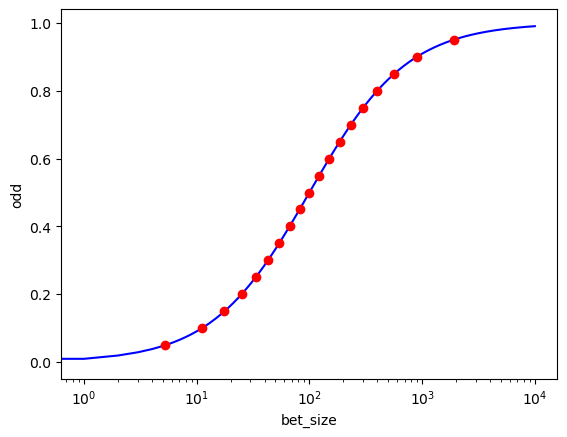

bet_size [   0.            5.26315789   11.11111111   17.64705882   25.
   33.33333333   42.85714286   53.84615385   66.66666667   81.81818182
  100.          122.22222222  150.          185.71428571  233.33333333
  300.          400.          566.66666667  900.         1900.        ]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
pot = 100
bet = np.arange(0, 10000, 1)
odd = bet/(pot+bet)

gap = 5
odd_ = np.arange(0, 100/100, 5/100)
bet_ = odd_/(1-odd_)*pot

plt.plot(bet, odd, 'b-')
plt.plot(bet_, odd_, 'ro')
plt.xlabel('bet_size')
plt.ylabel('odd')
plt.xscale('log')
plt.show()
print('bet_size', bet_)

In [596]:
import torch
from torch.distributions.categorical import Categorical
from tensordict.tensordict import TensorDict
import matplotlib.pyplot as plt

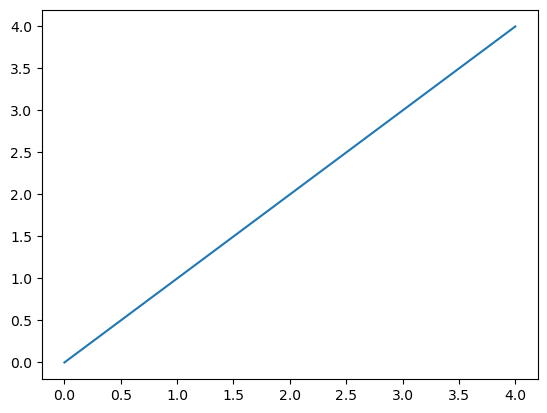

In [577]:
a = torch.arange(5)
b = torch.arange(5)
plt.plot(a, b)
plt.show()

In [592]:
l = [1, 3, 5]
l += [2, 4]
l[-7:]

[1, 3, 5, 2, 4]

In [614]:
l = [torch.rand(3) for _ in range(10)]
print(l[0])
torch.cat(l, dim=0)

tensor([0.6180, 0.5120, 0.2667])


tensor([0.6180, 0.5120, 0.2667, 0.7533, 0.4570, 0.8887, 0.0703, 0.0466, 0.2552,
        0.2034, 0.6982, 0.0577, 0.0975, 0.0807, 0.0727, 0.4867, 0.4932, 0.1978,
        0.6375, 0.6125, 0.5314, 0.3576, 0.9024, 1.0000, 0.9794, 0.8241, 0.6214,
        0.6505, 0.9792, 0.6844])

In [611]:
act_probs = torch.rand(22)
act_distr = Categorical(act_probs)
print(act_distr.logits)
act = act_distr.sample(torch.Size([1])).to(torch.int64)
print(act)
act_log_prob = act_distr.log_prob(act)
print(act_log_prob)

tensor([-3.6096, -2.5070, -3.8994, -3.0141, -2.9893, -2.9726, -5.2800, -3.0271,
        -2.4521, -5.9400, -4.0179, -2.7754, -3.8970, -3.9687, -2.9718, -3.6162,
        -2.4252, -3.1693, -2.6137, -2.9190, -3.0820, -2.5630])
tensor([16])
tensor([-2.4252])


In [561]:
d = {'1': 1}
for k, v in d.items():
    print(k, v)

1 1


In [546]:
player_idxes = torch.arange(0, 6, 1)
player_hand_ranks = torch.arange(0, 6, 1)
player_pot_chips = torch.rand(6)
sort_uniq_hand_ranks, winner_counts = player_hand_ranks.unique(sorted=True, return_counts=True)
for rank_idx in reversed(range(sort_uniq_hand_ranks.size(dim=0))):
    winner_idxes = player_idxes[player_hand_ranks==sort_uniq_hand_ranks[rank_idx]]
    num_of_winner = winner_counts[rank_idx]

    print(winner_idxes.to(torch.int).dtype)
    winner_pot_chips, sort_winner_idxes = player_pot_chips[winner_idxes.to(torch.int)].sort()

torch.int32
torch.int32
torch.int32
torch.int32
torch.int32
torch.int32


In [555]:
torch.tensor([0], dtype=torch.bool)


tensor([True])

In [479]:
#n = 10000
#card = torch.stack([torch.randperm(52) + 1 for _ in range(n)])[:, :5]
mom_card = torch.randperm(13, dtype=torch.int8, device='cpu') + 1
card = torch.combinations(mom_card, r=5)

def check_rank(card, return_highest=True):
    if card.ndim == 1:
        card = card.reshape(1, -1)
    
    val = (card - 1) % 13 + 2
    val = val.sort(dim=1, descending=True).values # sort the card val descendingly first for later check straight and rank of pairs
    suit = (card - 1) // 13
    rank = torch.zeros((card.size(dim=0), 6), dtype=card.dtype, device=card.device)
    RANK_ORDER = torch.tensor([15 ** 5, 15 ** 4, 15 ** 3, 15 ** 2, 15 ** 1, 1], dtype=torch.int32, device=card.device)
    SMALLEST_STRAIGHT = torch.tensor([14, 5, 4, 3, 2], dtype=card.dtype, device=card.device)

    for i, (v, s) in enumerate(zip(val, suit)):
        v, count = v.unique_consecutive(return_counts=True)
        if count.size(dim=0) == 5: # no any pair, maybe has straight and flush
            is_normal_straight = (v.diff() == -1).all(dim=0)
            is_smallest_straight = (v == SMALLEST_STRAIGHT).all(dim=0)
            is_straight = is_normal_straight | is_smallest_straight
            is_flush = (s == s[0]).all(dim=0)
            if is_straight:
                # determine the rank of straight
                if is_normal_straight:
                    rank[i, 1] = v[0]
                else: # is the smallest straight
                    rank[i, 1] = 5

                if is_flush: # straight flush
                    rank[i, 0] = 8
                else: # straight without flush (normal straight)
                    rank[i, 0] = 4
            elif is_flush:
                rank[i, 0] = 5
                rank[i, 1:6] = v
            else: # is only high card
                rank[i, 1:6] = v

        elif count.size(dim=0) == 4: # one pair
            rank[i, 0] = 1
            rank[i, 1] = v[count == 2]
        elif count.size(dim=0) == 3:  # two pair or set
            if 2 in count:  # if two pair
                rank[i, 0] = 2
                rank[i, 1:3] = v[count == 2]
                rank[i, 3] = v[count == 1]
            else: # is set
                rank[i, 0] = 3
                rank[i, 1] = v[count == 3]
        else: # full house or four of kind
            if 2 in count: # full house
                rank[i, 0] = 6
                rank[i, 1] = v[count == 3]
                rank[i, 2] = v[count == 2]
            else: # is four of kind
                rank[i, 0] = 7
                rank[i, 1] = v[count == 4]

    rank = (rank * RANK_ORDER).sum(dim=1)
    if return_highest:
        return rank.max(dim=0).values
    else:
        return rank

rank = check_rank(card, True)

print(rank)

tensor(6783750)


In [314]:
"""
rank
high = 0
pair = 1
two_pair = 2
set = 3
straight = 4
flush = 5
full house = 6
four_of_kind = 7
straight_flush = 8
"""

tensor([[1, 3, 4],
        [1, 2, 3]])


(tensor([[1, 3, 4],
         [1, 2, 3]]),
 tensor([1, 1, 1]))

In [662]:
l = torch.zeros((3, 5), device='mps')
a = l[0]
l[0] = 5
#a = 5
print(l)
print(a)
print(len(l))

tensor([[5., 5., 5., 5., 5.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='mps:0')
tensor([5., 5., 5., 5., 5.], device='mps:0')
3


In [637]:
l = [1, 2, 3]
a = l[0]
l[0] = 5
#a = 5
print(l)
print(a)

[5, 2, 3]
1


In [639]:
from torch import zeros
zeros(3)

tensor([0., 0., 0.])

In [708]:
l1 = [1, 2, 3]
l2 = l1.copy()
l1[0] = 0
print(l1, l2)

[0, 2, 3] [1, 2, 3]


In [712]:
class C():
    def __init__(self):
        self.__a = 1

    def get_a(self):
        return self.__a
    
    def set_a(self,x):
        self.__a = x

c = C()
c.set_a(2)
c.get_a()

2

In [690]:
[1, 2][l1[0].to(torch.int64).item()]

1

In [696]:
d = {'a': 1}
a = d.copy()
d['a'] = 2
print(a, d)

{'a': 1} {'a': 2}


In [664]:
torch.arange(8, dtype=torch.int)

tensor([0, 1, 2, 3, 4, 5, 6, 7], dtype=torch.int32)

In [674]:
t = torch.zeros(3, requires_grad=True).detach()
s = t.sum()
print('S', s)

S tensor(0.)


In [678]:
max_num_of_player = 6
num_of_player = 2
player_idxes = torch.arange(max_num_of_player, dtype=torch.int64, device='mps')
has_player = (player_idxes < num_of_player)
print(has_player.to(torch.float32).device)

mps:0


In [736]:
[0, 1][torch.tensor(1, dtype=torch.int8).item()]

1

In [762]:
a = torch.tensor([0, 0, 0], dtype=torch.bool)
~a.any()

tensor(True)

In [744]:
a = 3
if a < 1:
    print(a)
elif a < 2:
    print(a)
else:
    print(a)

3


In [766]:
torch.cat([torch.zeros(1,3) for _ in range(4)], dim=0)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])